# SiSEC MUS 2018 Plots and Statistical Analysis

In this notebook the objective results of the [2018 SiSEC MUS](https://github.com/sigsep/sigsep-mus-2018) task are analysed. In the evaluation campaign, participants submitted source separation systems that target the task of music separation: given a stereo music track, the task is to separate it into four stems _vocals, drums, bass, other_ and the _accompaniment_ (all stems except the vocals.) 

## Evaluation metrics

In this SiSEC, we decided to drop the assumption that distortion filters could be varying over time, but considered instead they are fixed for the whole length of the track. First, this significantly reduces the computational cost because matching is done only once for the whole signal. Second, this introduces more dynamics in the evaluation, because time-varying matching filters over-estimate performance, as we show later. Third, this makes matching more stable, because sources are never silent throughout the whole recording, while they often were for short windows. The results were computed using the new [bssevalv4](https://github.com/sigsep/sigsep-mus-eval) Python tools.



## Imports

In [0]:
!pip install -q scikit_posthocs
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import scikit_posthocs as sp
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.transforms import BlendedGenericTransform
import scikit_posthocs as sp
from urllib.request import urlopen
from google.colab import files

sns.set()
sns.set_context("notebook")

## Download Data, Setting up Variables

In [0]:
#@title Set Data Source
url = "https://github.com/sigsep/sigsep-mus-2018-analysis/releases/download/v1.0.0/sisec18_mus.pandas" #@param {type:"string"}

In [0]:
metrics = ['SDR', 'SIR', 'SAR', 'ISR']
targets = ['vocals', 'accompaniment', 'drums', 'bass', 'other']
oracles = [
    'IBM1', 'IBM2', 'IRM1', 'IRM2', 'MWF',
]

In [0]:
# Open URL
raw_data = urlopen(url)
# Load into Pandas Dataframes
df = pd.read_pickle(raw_data)
# destingish oracles from non-oracle methods
df['oracle'] = df.method.isin(oracles)

# Aggregate all frames of each track using the median
# Note that `nan` values are skipped by default
df = df.groupby(
    ['method', 'track', 'target', 'metric']
).median().reset_index()

## All Methods (Boxplots)

These boxplots present the main results of the sisec as they show all the BSSeval scores of the evaluation. For each track, the median value of the score was taken and used for the boxplots.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:482: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data[hue_mask])


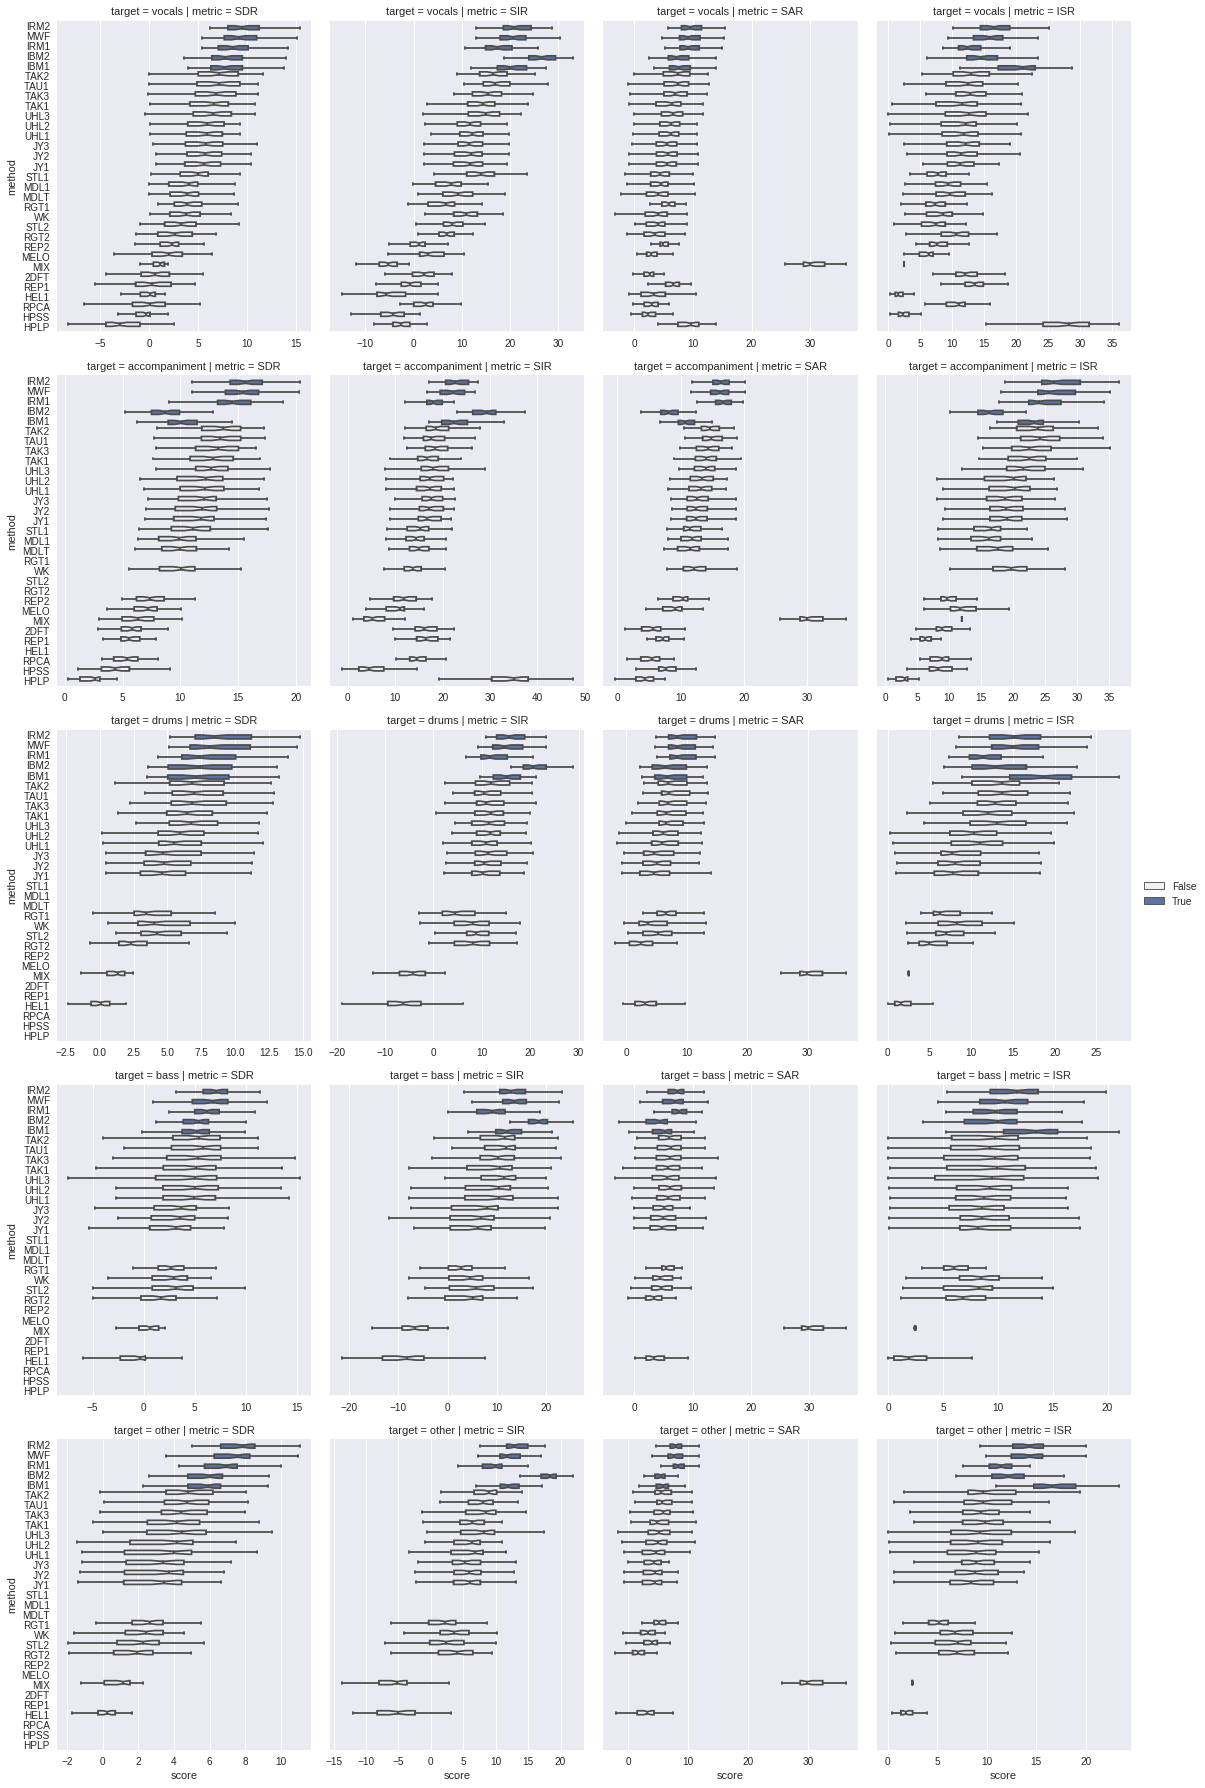

In [5]:
# Get sorting keys (sorted by median of SDR:vocals)
df_sort_by = df[
    (df.metric == "SDR") &
    (df.target == "vocals")
]

# sort methods by score
methods_by_sdr = df_sort_by.score.groupby(
    df_sort_by.method
).median().sort_values().index.tolist()
      
g = sns.FacetGrid(
    df, row="target", col="metric", 
    row_order=targets, col_order=metrics, 
    size=5, sharex=False, aspect=0.8
)
g = (g.map(
    sns.boxplot,
    "score", 
    "method",
    "oracle",
    orient='h',
    order=methods_by_sdr[::-1],
    showfliers=False,
    notch=True
).add_legend())

# Trackwise Heatmap

In this figure, we display heatmaps of the trackwise BSSeval scores for the to show the differences between the separation result of different systems on all test tracks.

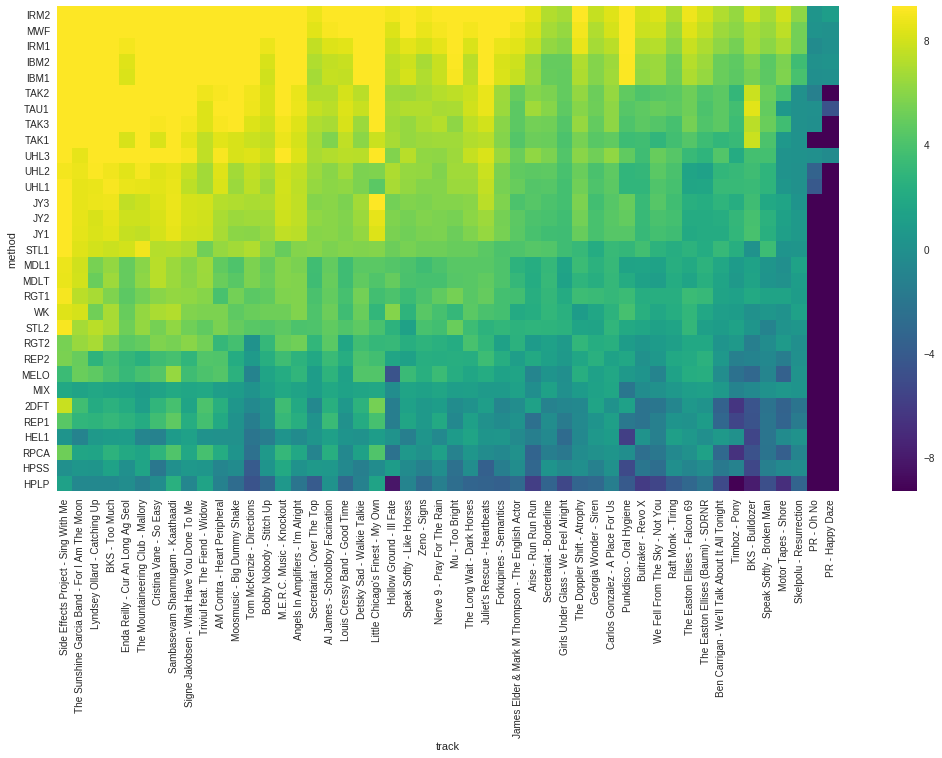

In [6]:
target = 'vocals'
f, ax = plt.subplots(1,1, figsize=(16, 10))

df_target = df[(df.target == target) & (df.metric == 'SDR')]

targets_by_score = df_target.score.groupby(
    df_target.method
).median().sort_values().index.tolist()

tracks_by_score = df_target.score.groupby(
  df_target.track
).median().sort_values().index.tolist()

pivoted = pd.pivot_table(df_target, values='score', index='method', columns='track')

pivoted = pivoted.reindex(index=targets_by_score[::-1], columns=tracks_by_score[::-1])
sns.heatmap(
  pivoted, square=True, ax=ax, cmap='viridis', vmin=np.percentile(pivoted, 10), vmax=np.percentile(pivoted, 90)
)
for label in ax.get_yticklabels():
  label.set_rotation(0)  

f.tight_layout()

# Statistical Significance tests

## Friedmann Test

A Friedman test reveals a significant effect of separation method on the metric (SDR). As such it reveals the probability that there are significant differences in the position of the medians between the methods.

In [7]:
for target in targets:
    df_target = df[
          (df.target == target) & (df.metric == "SDR")
    ]
    chi2_test, p_test = scipy.stats.friedmanchisquare(
       *[
          df_target[df_target["method"] == i]["score"]
          for i in np.unique(df_target["method"].values)
       ]
    )

    print("Chi^2: %s " % target, chi2_test)
    print("P-value: ", p_test)

Chi^2: vocals  1386.6372580645166
P-value:  5.458122037656908e-273
Chi^2: accompaniment  1167.5993650793653
P-value:  9.612861559486457e-230
Chi^2: drums  858.86961038961
P-value:  4.408821069467607e-169
Chi^2: bass  731.9675835735994
P-value:  3.779507904771285e-142
Chi^2: other  833.9625974025976
P-value:  8.670857307430979e-164


## Pairwise comparison test

Running a post-hoc comparison test using Conover-Iman to assess which methods perform signiﬁcantly better than others, for different targets.

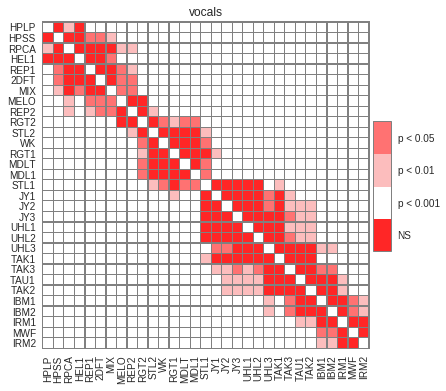

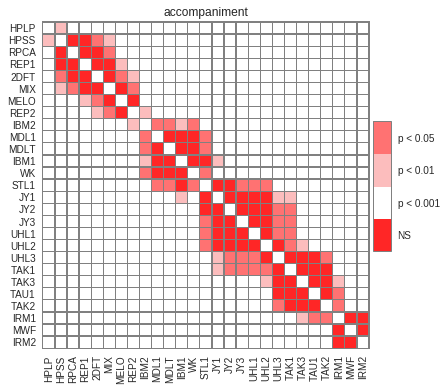

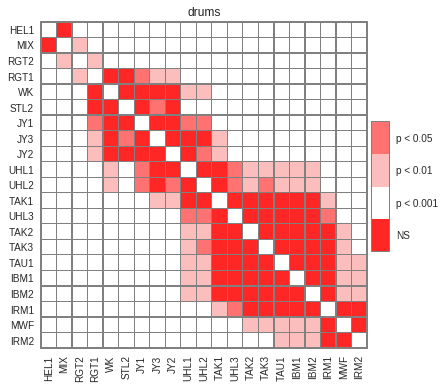

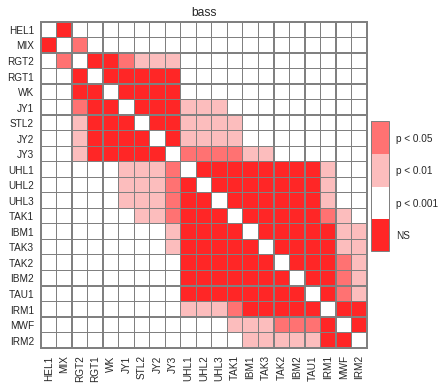

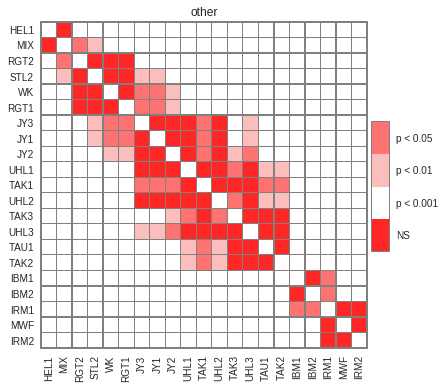

In [8]:
# resort them by median SDR
# Get sorting keys (sorted by median of SDR:vocals score)

for target in targets:
    df_voc = df[(df.target == target) & (df.metric == "SDR")].copy()

    targets_by_voc_sdr = df_voc.score.groupby(
        df_voc.method
    ).median().sort_values().index.tolist()

    # get the two sortings
    df_voc['method'] = df_voc['method'].astype(pd.api.types.CategoricalDtype(categories=targets_by_voc_sdr, ordered=True))

    # # prepare the pairwise plots
    pc_voc = sp.posthoc_conover(df_voc, val_col='score', group_col='method')

    f_voc = plt.figure(figsize=(6, 6))
    # Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
    cmap = ['1', '#ff2626',  '#ffffff', '#fcbdbd', '#ff7272']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.90, 0.35, 0.04, 0.3]}
    ax, cb = sp.sign_plot(pc_voc, **heatmap_args)
    ax.set_title(target)